In [1]:
# From Robust Optimization - Ben-Tal, El Ghaoui, Nemirovski (2009)
# Example 1.1
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
np.random.seed(0)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [2]:
# Set seed for reproducibility
np.random.seed(0)

# Problem parameters
c = np.array([100,      # purchase raw material 1 (kg)
              199.9,    # purchase raw material 2 (kg)
              -5500,    # produce drug 1 (1000 packs)
              -6100])   # produce drug 2 (1000 packs)
A = np.array([[-0.01, -0.02, 0.5, 0.6],  # balance of active agent
              [1, 1, 0, 0],              # storage
              [0, 0, 90, 100],           # manpower
              [0, 0, 40, 50],            # equipment
              [100, 199.9, 700, 800]])    # budget
b = np.array([0, 1000.0, 2000, 800, 100000])
m, n = A.shape

In [3]:
# Solve non-robust problem
x_non_robust = cp.Variable(n, nonneg=True)
objective_non_robust = cp.Minimize(c @ x_non_robust)
constraints_non_robust = [A @ x_non_robust <= b]
prob_non_robust = cp.Problem(objective_non_robust, 
                             constraints_non_robust)
prob_non_robust.solve(solver=cp.CLARABEL, verbose=False)

nominal_value = prob_non_robust.value
print("Nominal value: %.2f, Profit: %.2f %%" % (nominal_value, -nominal_value/1000))
print("Production: drug 1 = %.2f, drug 2 = %.2f" % (x_non_robust.value[2], x_non_robust.value[3]))
print("Purchase: raw material 1 = %.2f, raw material 2 = %.2f" % (x_non_robust.value[0], x_non_robust.value[1]))

Nominal value: -8819.66, Profit: 8.82 %
Production: drug 1 = 17.55, drug 2 = 0.00
Purchase: raw material 1 = 0.00, raw material 2 = 438.79


In [4]:
# Random perturbations of the data
num_tests = 10**4
absolute_changes = np.zeros(num_tests)
relative_changes = np.zeros(num_tests)

for i in range(num_tests):
    x_val = x_non_robust.value
    delta_1 = .5e-2 * abs(A[0, 0]) * (1 - 2 * np.random.rand())   # Vary 5% of nominal value
    delta_2 = 2e-2 * abs(A[0, 1]) * (1 - 2 * np.random.rand())   # Vary 2% of nominal value
    if delta_2 > 0:
        # Must reduce output of drug I to handle balance constraint
        x_val[2] = -(A[0, 1] + delta_2) * x_val[1] / A[0, 2]
    absolute_changes[i] = c @ x_val - nominal_value
    relative_changes[i] = abs(absolute_changes[i]) / abs(nominal_value)

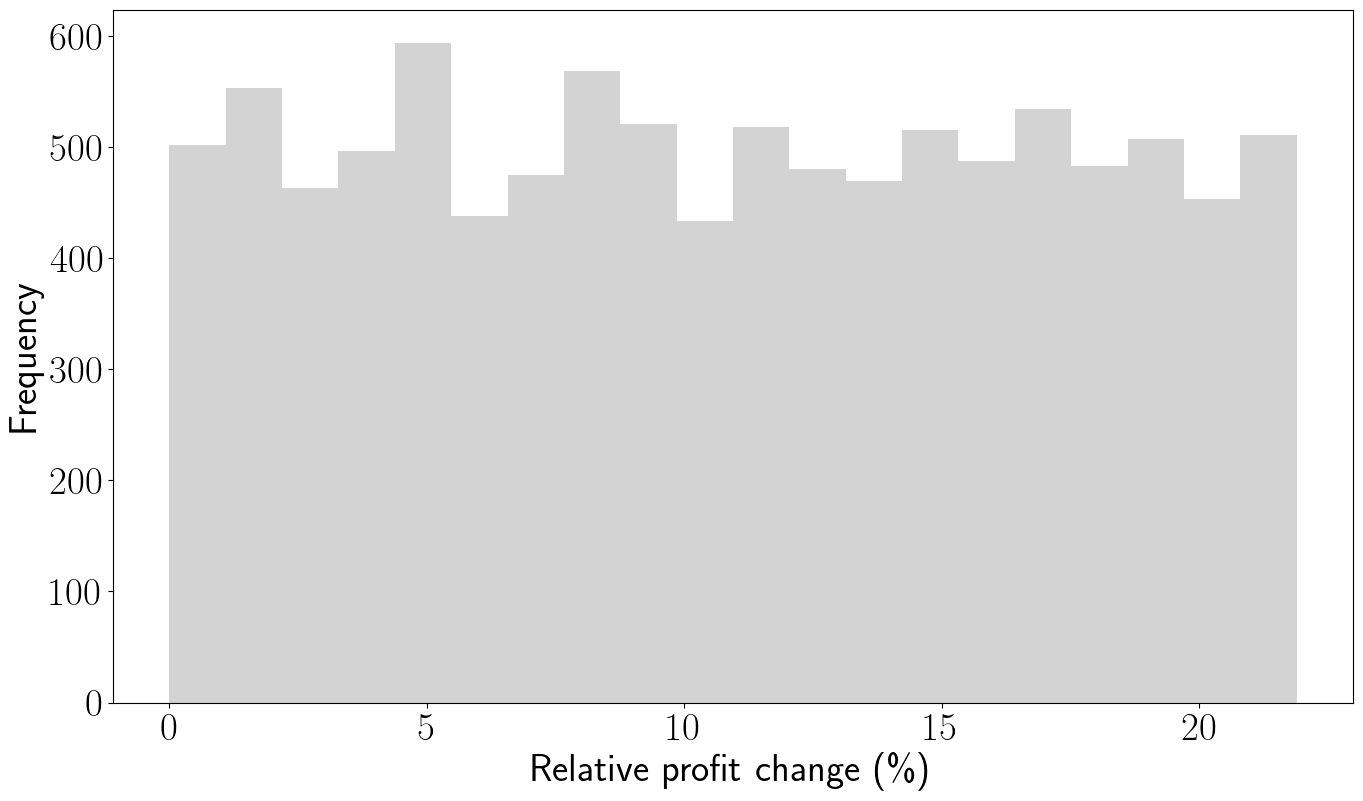

In [5]:
# Plot the histogram
fig, ax = plt.subplots(figsize=(16, 9))
plt.hist(relative_changes * 100, bins=20, color="lightgray")
plt.xlabel("Relative profit change (\%)")
plt.ylabel("Frequency")
# plt.title("")
plt.savefig("pricing_changes.pdf", bbox_inches="tight")
plt.show()

In [6]:
# Solve robust problem (alternative
x_robust = cp.Variable(n, nonneg=True)
objective = cp.Minimize(c @ x_robust)

a = A[0, :]
M = np.diag([5e-05, 4e-04, 0, 0])
constraints = [a @ x_robust + cp.norm(M.T @ x_robust, 1) <= 0]

for i in range(1, m):
    constraints.append(A[i, :] @ x_robust <= b[i])

prob_robust = cp.Problem(objective, constraints)
prob_robust.solve(solver=cp.CLARABEL, verbose=False)

abs_loss = abs(c @ x_robust.value - c @ x_non_robust.value)
rel_loss = abs_loss / abs(c @ x_non_robust.value)

print("Absolute degradation from nominal value: \t%.2f" % abs_loss)
print("Absolute degradation from nominal profit: \t%.2f %%" % (abs_loss / 1000))
print("Relative degradation from nominal profit: \t%.2f %%\n" % (rel_loss * 100))

print("Production: drug 1 = %.2f, drug 2 = %.2f" % (x_robust.value[2], x_robust.value[3]))
print("Purchase: raw material 1 = %.2f, raw material 2 = %.2f" % (x_robust.value[0], x_robust.value[1]))

Absolute degradation from nominal value: 	318.34
Absolute degradation from nominal profit: 	0.32 %
Relative degradation from nominal profit: 	3.70 %

Production: drug 1 = 17.47, drug 2 = 0.00
Purchase: raw material 1 = 877.73, raw material 2 = 0.00


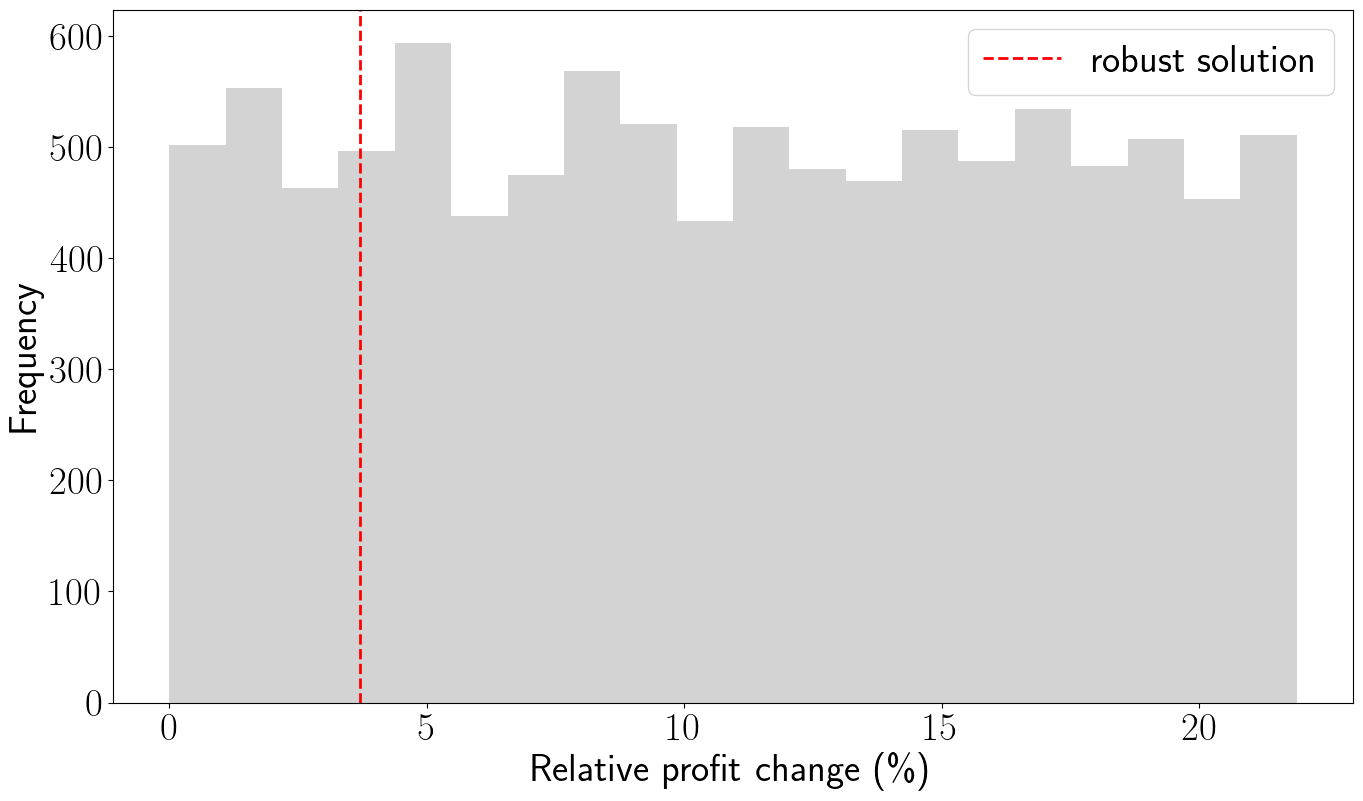

In [7]:
# Plot the histogram
fig, ax = plt.subplots(figsize=(16, 9))
plt.hist(relative_changes * 100, bins=20, color="lightgray")
plt.xlabel("Relative profit change (\%)")
plt.ylabel("Frequency")
plt.axvline(rel_loss * 100, color="red", linestyle="--", linewidth=2, label="robust solution")
plt.legend()
plt.savefig("pricing_changes_with_ro.pdf", bbox_inches="tight")
plt.show()